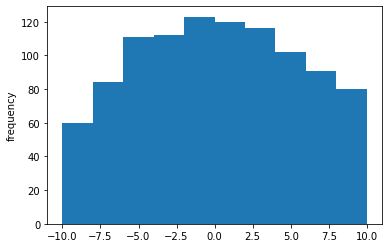

In [67]:
# -*- coding: utf-8 -*-
"""
@author: Yichao Chen
"""
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

np.random.seed(1)

# global variables
epsilon = 0.9  # initial greedy police
alpha = 0.1  # initial learning rate
gamma = 0.999  # discount factor
niter = int(1e3)
NT = int(10)  # 10 periods
dt = 1  # send child order each dt
dT = 60  # decisions are made at each dT

kappa = 1/60  # second time scale
theta = 1
sigma = 0.02/np.sqrt(60)
phi = 0.000001
c = 1000

Qmax = 10  # max inventory
Qmin = -10  # min inventory
q_grid = list(range(Qmin, Qmax + 1))

a_grid = list(range(-5, 6))  # actions
# a_grid.reverse
a_grid.remove(0)
a_grid = [0] + a_grid

s_min = theta - 5 * sigma / np.sqrt(2 * kappa)  # min price
s_max = theta + 5 * sigma / np.sqrt(2 * kappa)  # max price
Ns = 51
ds = (s_max - s_min) / (Ns - 1)
s_grid = np.arange(s_min, s_max + ds / 2, ds).tolist()


def randargmax(b):
    return np.random.choice(np.flatnonzero(b == b.max()))


# initialize q table
def init_q_table(size_s, size_T, size_q, size_a):
    """
    Initialize q table.
    :param size_s: length of s_grid
    :param size_T: number of periods
    :param size_q: length of q_grid
    :param size_a: length of a_grid
    :type size_s: int
    :type size_T: int
    :type size_q: int
    :type size_a: int
    :return: q_table
    :rtype: numpy.ndarray
    """

    table = np.zeros([size_s, size_T + 1, size_q, size_a])
    return table


def init_state_matrices():
    s_matrix = np.zeros([niter, NT + 1])
    q_matrix = np.zeros([niter, NT + 1])
    a_matrix = np.zeros([niter, NT + 1])
    return s_matrix, q_matrix, a_matrix


def init_r_matrix():
    return np.zeros([niter, NT + 1])


#
def get_action(s, T, q, q_table, epsilon):
    """
    return the epsilon_greedy action given a state
    :param s: spot price
    :param T: trading period
    :param q: inventory
    :param q_table: table of Q values
    :param epsilon: greedy policy
    :type s: float
    :type T: int
    :type q: int
    :type q_table: numpy.ndarray
    :type epsilon: float
    :return: epsilon_greedy action
    :rtype: int
    """
    if np.random.uniform() > epsilon:
        action = np.random.choice(adms_actions(q))
    else:
        action_sub_index = randargmax(q_table[s_grid.index(s), T, q_grid.index(q), adms_actions_indeces(q)])
        # action_sub_index = np.argmax(q_table[s_grid.index(s), T, q_grid.index(q), adms_actions_indeces(q,a_grid)])
        action = adms_actions(q)[action_sub_index]
    return action


def adms_actions(q):
    """
    return admissible actions at q
    :param q: inventory
    :type q: int
    :return: admissible actions
    :rtype: list
    """
    lowerbound = max(-5, -10 - q)
    upperbound = min(5, 10 - q)
    return [item for item in a_grid if (lowerbound <= item <= upperbound)]


def adms_actions_indeces(q):
    """
    return the indices of admissible actions in a_grid
    :param q: inventory
    :type q: int
    :return: indices of admissible actions in a_grid
    :rtype: numpy.ndarray
    """
    return np.where(np.isin(a_grid, adms_actions(q)))[0]


def get_feedback(s, T, q, a):
    period_reward = 0
    q0 = q
    x = a / dT  # average order size per dt
    t = 1
    while t < dT + 1:
        reward_, q, s = SimMRStep(s, q, x, kappa, theta, sigma, dt, phi)
        period_reward += reward_
        t += 1
    return s_grid[abs(s - np.array(s_grid)).argmin()], q0 + a, period_reward


def get_last_feedback(s, T, q, a):
    period_reward = 0
    q0 = q
    x = a / dT  # average order size per dt
    t = 1
    while t < dT + 1:
        reward_, q, s = SimMRStep(s, q, x, kappa, theta, sigma, dt, phi)
        period_reward += reward_
        t += 1
    reward_, q_, s_ = SimMRStep(s, q, x, kappa, theta, sigma, dt, phi)
    terminal_reward = q * (s_ - s) - c * phi * np.square(q)
    period_reward += terminal_reward

    return s_grid[abs(s - np.array(s_grid)).argmin()], q0 + a, period_reward


# simulate one mean recursion step
def SimMRStep(S0, q0, x, kappa, theta, sigma, dt, phi):
    S1 = theta + (S0 - theta) * np.exp(-kappa * dt) + sigma * np.sqrt(dt) * np.random.randn()
    # S1 = S0 + kappa*(theta-S0)* dt + sigma * np.sqrt(dt) * np.random.randn()
    # x(i+1) = x(i)+th*(mu-x(i))*dt+sig*sqrt(dt)*randn
    q1 = q0 + x
    # phi = 0
    # reward = q0 * (S1 - S0) - phi * np.square(x)
    reward = q0 * (S1 - S0) - phi * np.square(x)
    return reward, q1, S1


# define epsilon-greedy q learning for optimal execution
def q_learning():
    s_matrix, q_matrix, a_matrix = init_state_matrices()
    r_matrix = init_r_matrix()
    q_table = init_q_table(len(s_grid), NT, len(q_grid), len(a_grid))
    for episode in range(int(niter)):
        epsilon = 1 - max(1 / (1 + episode), 0.2)  # greedy police
        alpha = 1 / (1 + episode)
        T = 0
        s = np.random.choice(s_grid)
        q = np.random.choice(q_grid)  # should set this to 0
        while T < NT - 1:
            a = get_action(s, T, q, q_table, epsilon)  # choose epsilon-greedy action
            s_, q_, r = get_feedback(s, T, q, a)  # get next state and the current reward
            q_predict = q_table[s_grid.index(s), T, q_grid.index(q), a_grid.index(a)]  # get Q(s,T,q,a)
            q_target = r + gamma * q_table[s_grid.index(s_), T + 1, q_grid.index(q_), adms_actions_indeces(
                q_)].max()  # r+gamma*argmax_{a'} Q(s_,T+1,q_,a')
            q_table[s_grid.index(s), T, q_grid.index(q), a_grid.index(a)] += alpha * (q_target - q_predict)
            # Q(s,T,q,a)<- Q(s,T,q,a)- alpha*Q(s,T,q,a)+ alpha*(r+gamma*argmax_{a'} Q(s_,T+1,q_,a'))

            # store the states and actions
            s_matrix[episode, T] = s
            q_matrix[episode, T] = q
            a_matrix[episode, T] = a
            r_matrix[episode, T] = r
            s = s_
            q = q_
            T += 1

        # update last period with different feedback
        a = get_action(s, T, q, q_table, epsilon)
        s_, q_, r = get_last_feedback(s, T, q, a)
        q_predict = q_table[s_grid.index(s), T, q_grid.index(q), a_grid.index(a)]
        q_target = r + gamma * q_table[s_grid.index(s_), T + 1, q_grid.index(q_), adms_actions_indeces(q_)].max()
        q_table[s_grid.index(s), T, q_grid.index(q), a_grid.index(a)] += alpha * (q_target - q_predict)

        s_matrix[episode, T] = s
        q_matrix[episode, T] = q
        a_matrix[episode, T] = a
        r_matrix[episode, T] = r
        s_matrix[episode, T + 1] = s_
        q_matrix[episode, T + 1] = q_

        # s = s_
        # q = q_
    return q_table, s_matrix, q_matrix, a_matrix, r_matrix


def get_optimal_actions(T):
    optimal_action_table = np.zeros([len(s_grid), len(q_grid)])
    for i in range(np.shape(q_table)[0]):
        for j in range(np.shape(q_table)[2]):
            optimal_action_table[i, j] = adms_actions(q_grid[j])[
                np.argmax(q_table[i, T, j, adms_actions_indeces(q_grid[j])])]
            # optimal_action_table[i,j]= a_grid[np.argmax(q_table[:,T,:,:],axis=-1)[i,j]]
    return pd.DataFrame(optimal_action_table, columns=q_grid, index=s_grid)


def plot_actions(T):
    # Get a data set of optimal actions for pairs (inventory,price)
    # At a fixed time
    # Generate sample data
    # Columns are x axis (inventory) and rows are y axis (price)

    cmap = sns.diverging_palette(20, 240, as_cmap=True)  # husl color system
    heat_map = sns.heatmap(get_optimal_actions(T), cmap=cmap)
    plt.xlabel("Inventory")
    plt.ylabel("Price")
    plt.show()


class Model():
    def __init__(self, size_s, size_T, size_q, size_a):
            self.transitions = np.zeros([size_s, size_T + 1, size_q, size_a], dtype = object)
            self.rewards = np.zeros([size_s, size_T + 1, size_q, size_a])
            
    def add(self,s,T,q,a,s_,q_,r):
        self.transitions[s_grid.index(s), T, q_grid.index(q), a_grid.index(a)] = [s_, T+1, q_]
        self.rewards[s_grid.index(s), T, q_grid.index(q), a_grid.index(a)] = r
    
    def sample(self):
        """ Return random state, action"""
        # Choose a visited state
        states_indeces = np.column_stack(np.nonzero(self.transitions))
    
        pick_s =  np.random.randint(0, np.shape(states_indeces)[0])
       
        picked_state_index = states_indeces[pick_s][:-1]
        
        s = s_grid[picked_state_index[0]]
        T = picked_state_index[1]
        q = q_grid[picked_state_index[2]]
        # Choose a visited action at that state
        
        t = np.nonzero(self.transitions[picked_state_index[0],picked_state_index[1],picked_state_index[2]])[0]
 
        picked_action_index = np.random.choice(t)
        a = a_grid[picked_action_index]

        return s, T, q, a
    
    def feedback(self, s,T,q,a):
        state = self.transitions[s_grid.index(s), T, q_grid.index(q), a_grid.index(a)]
        r = self.rewards[s_grid.index(s), T, q_grid.index(q), a_grid.index(a)]
        return state[0], state[2], r

def planning(n, model,q_table):
    for i in range(n):
        s, T, q, a =  model.sample()
        s_, q_, r = model.feedback(s, T, q, a)
        q_predict = q_table[s_grid.index(s), T, q_grid.index(q), a_grid.index(a)]  # get Q(s,T,q,a)
        q_target = r + gamma * q_table[s_grid.index(s_), T + 1, q_grid.index(q_), adms_actions_indeces(q_)].max()  
        # r+gamma*argmax_{a'} Q(s_,T+1,q_,a')
        q_table[s_grid.index(s), T, q_grid.index(q), a_grid.index(a)] += alpha * (q_target - q_predict)
    

def dyn_q_learning():
    s_matrix, q_matrix, a_matrix = init_state_matrices()
    r_matrix = init_r_matrix()
    q_table = init_q_table(len(s_grid), NT, len(q_grid), len(a_grid))
    model = Model(len(s_grid), NT, len(q_grid), len(a_grid))
    n = 5 #number of steps in planning
    for episode in range(int(niter)):
        epsilon = 1 - max(1 / (1 + episode), 0.2)  # greedy police
        alpha = 1 / (1 + episode)
        T = 0
        s = np.random.choice(s_grid)
        #q = np.random.choice(q_grid)  # should set this to 0
        q = 0
        while T < NT - 1:
            #take action and get feedback
            a = get_action(s, T, q, q_table, epsilon)  # choose epsilon-greedy action
            s_, q_, r = get_feedback(s, T, q, a)  # get next state and the current reward
            
            #q_learning
            q_predict = q_table[s_grid.index(s), T, q_grid.index(q), a_grid.index(a)]  # get Q(s,T,q,a)
            q_target = r + gamma * q_table[s_grid.index(s_), T + 1, q_grid.index(q_), adms_actions_indeces(q_)].max() 
            # r+gamma*argmax_{a'} Q(s_,T+1,q_,a')
            q_table[s_grid.index(s), T, q_grid.index(q), a_grid.index(a)] += alpha * (q_target - q_predict)
            # Q(s,T,q,a)<- Q(s,T,q,a)- alpha*Q(s,T,q,a)+ alpha*(r+gamma*argmax_{a'} Q(s_,T+1,q_,a'))

            #learn model 
            
            model.add(s,T,q,a,s_,q_,r)
            
            #planning n septs with model
            planning(n, model,q_table)
            
            # store the states and actions
            s_matrix[episode, T] = s
            q_matrix[episode, T] = q
            a_matrix[episode, T] = a
            r_matrix[episode, T] = r
            
            #Set next state
            s = s_
            q = q_
            T += 1
 
        # update last period with different feedback
        a = get_action(s, T, q, q_table, epsilon)
        s_, q_, r = get_last_feedback(s, T, q, a)
        

        q_predict = q_table[s_grid.index(s), T, q_grid.index(q), a_grid.index(a)]
        q_target = r + gamma * q_table[s_grid.index(s_), T + 1, q_grid.index(q_), adms_actions_indeces(q_)].max()
        q_table[s_grid.index(s), T, q_grid.index(q), a_grid.index(a)] += alpha * (q_target - q_predict)

        #learn model 
        model.add(s,T,q,a,s_,q_,r)
            
        #planning n septs with model
        planning(n, model,q_table)
        
        s_matrix[episode, T] = s
        q_matrix[episode, T] = q
        a_matrix[episode, T] = a
        r_matrix[episode, T] = r
        s_matrix[episode, T + 1] = s_
        q_matrix[episode, T + 1] = q_

        # s = s_
        # q = q_
    return q_table, s_matrix, q_matrix, a_matrix, r_matrix

if __name__ == '__main__':
    q_table, s_matrix, q_matrix, a_matrix, r_matrix = dyn_q_learning()
    plt.hist(q_matrix[:-1, -1])
    plt.ylabel("frequency")

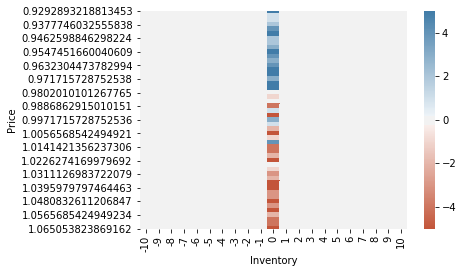

In [75]:
plot_actions(0)

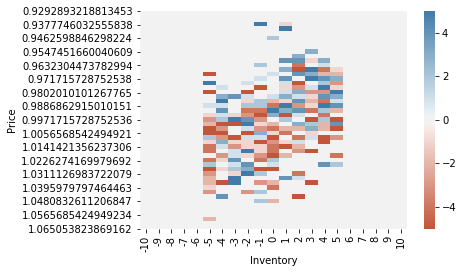

In [77]:
plot_actions(1)

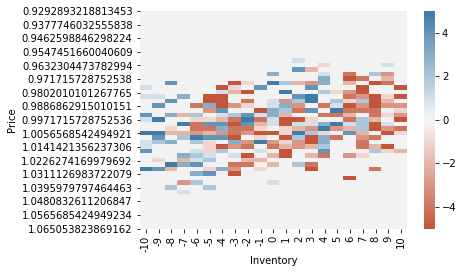

In [71]:
plot_actions(5)

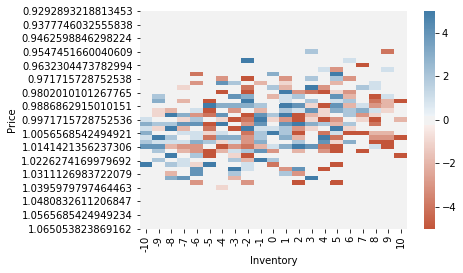

In [69]:
plot_actions(7)

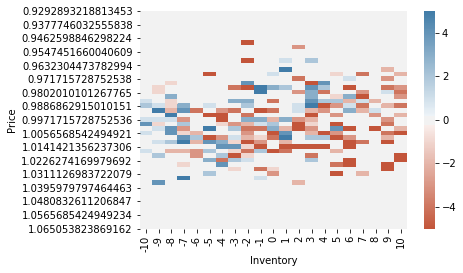

In [74]:
plot_actions(9)